In [13]:
import math
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from geocube.api.core import make_geocube
import rioxarray
import xesmf as xe
from cutshapefile import transform_from_latlon, rasterize
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

### Processing - Complete, go to bottom

In [ ]:
df_obs = pd.read_csv(
    f"/nfs/a68/earlacoa/china_measurements_corrected/df_obs_o3_6mDM8h_ppb_PM2_5_DRY.csv",
    index_col="datetime",
    parse_dates=True,
)['2015']

In [ ]:
gdf = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/china_regions.shp')

polygon_north_china = gdf.loc[gdf.region == 'North China'].geometry
polygon_north_east_china = gdf.loc[gdf.region == 'North East China'].geometry
polygon_east_china = gdf.loc[gdf.region == 'East China'].geometry
polygon_south_central_china = gdf.loc[gdf.region == 'South Central China'].geometry
polygon_south_west_china = gdf.loc[gdf.region == 'South West China'].geometry
polygon_north_west_china = gdf.loc[gdf.region == 'North West China'].geometry

regions = []
for index, obs in df_obs.iterrows():
    point = Point(obs['station_lon'], obs['station_lat'])
    if polygon_north_china.contains(point).values[0]:
        region = 'North China'
    elif polygon_north_east_china.contains(point).values[0]:
        region = 'North East China'
    elif polygon_east_china.contains(point).values[0]:
        region = 'East China'
    elif polygon_south_central_china.contains(point).values[0]:
        region = 'South Central China'
    elif polygon_south_west_china.contains(point).values[0]:
        region = 'South West China'
    elif polygon_north_west_china.contains(point).values[0]:
        region = 'North West China'
        
    regions.append(region)
    
df_obs['regions'] = regions
#df_obs.to_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/df_obs_with_regions.csv')

In [ ]:
gdf = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_1.shp')

polygons = {}
for index, province in gdf.iterrows():
    polygons.update({province.NAME_1: province.geometry})
    
provinces = []
for index, obs in df_obs.iterrows():
    point = Point(obs['station_lon'], obs['station_lat'])
    
    matching_province = 'None'
    for province, polygon in polygons.items():
        if polygon.contains(point):
            matching_province = province
            
    provinces.append(matching_province)
            
df_obs['provinces'] = provinces

df_obs.loc[df_obs.station_id == '1600A', 'provinces'] = 'Liaoning'
df_obs.loc[df_obs.station_id == '2501A', 'provinces'] = 'Guangxi'
df_obs.loc[df_obs.station_id == '1313A', 'provinces'] = 'Shandong'

#df_obs.to_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/df_obs_with_regions_and_provinces.csv')

In [ ]:
df_obs = pd.read_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/df_obs_with_regions_and_provinces.csv')
df_obs.head()

In [ ]:
ds_PM2_5_DRY = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/PM2_5_DRY/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_PM2_5_DRY_popgrid_0.25deg.nc')['PM2_5_DRY']
ds_o3_6mDM8h = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/o3_6mDM8h/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_o3_6mDM8h_popgrid_0.25deg.nc')['o3_6mDM8h']

In [ ]:
def normalised_mean_bias_factor(obs_values, wrf_values):
    if ( np.nansum(( obs_values / np.nansum(obs_values) ) * ( ( wrf_values - obs_values) / obs_values )) ) > 0.0:
        overestimates = True
    else:
        overestimates = False
    if overestimates:
        return np.nansum(( obs_values / np.nansum(obs_values) ) * ( ( wrf_values - obs_values) / obs_values ))
    else:
        return np.nansum(( wrf_values / np.nansum(wrf_values) ) * ( ( wrf_values - obs_values) / obs_values ))


def normalised_mean_absolute_error_factor(obs_values, wrf_values):
    if ( np.nansum(( obs_values / np.nansum(obs_values) ) * ( ( wrf_values - obs_values) / obs_values )) ) > 0.0:
        overestimates = True
    else:
        overestimates = False
    if overestimates:
        return np.nansum(( obs_values / np.nansum(obs_values) ) * ( np.abs(( wrf_values - obs_values)) / obs_values ))
    else:
        return np.nansum(( wrf_values / np.nansum(wrf_values) ) * ( np.abs(( wrf_values - obs_values)) / obs_values ))

In [ ]:
emulator_PM2_5_DRY = []
emulator_o3_6mDM8h = []
nmbf_PM2_5_DRY = []
nmbf_o3_6mDM8h = []
nmaef_PM2_5_DRY = []
nmaef_o3_6mDM8h = []
error_PM2_5_DRY = []
error_o3_6mDM8h = []
scaling_factors_PM2_5_DRY = []
scaling_factors_o3_6mDM8h = []
for index, obs in df_obs.iterrows():
    nearest_PM2_5_DRY = ds_PM2_5_DRY.sel(lat=obs['station_lat'], method="nearest").sel(lon=obs['station_lon'], method="nearest").values
    nearest_o3_6mDM8h = ds_o3_6mDM8h.sel(lat=obs['station_lat'], method="nearest").sel(lon=obs['station_lon'], method="nearest").values
    
    emulator_PM2_5_DRY.append(nearest_PM2_5_DRY)
    emulator_o3_6mDM8h.append(nearest_o3_6mDM8h)
    
    nmbf_PM2_5_DRY.append(normalised_mean_bias_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY))
    nmbf_o3_6mDM8h.append(normalised_mean_bias_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h))
    
    nmaef_PM2_5_DRY.append(normalised_mean_absolute_error_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY))
    nmaef_o3_6mDM8h.append(normalised_mean_absolute_error_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h))
    
    error_PM2_5_DRY.append(obs['PM2_5_DRY'] * normalised_mean_bias_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY))
    error_o3_6mDM8h.append(obs['o3_6mDM8h_ppb'] * normalised_mean_bias_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h))
    
    scaling_factor_PM2_5_DRY = (1 - ((obs['PM2_5_DRY'] * normalised_mean_bias_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY)) / nearest_PM2_5_DRY))
    scaling_factors_PM2_5_DRY.append(scaling_factor_PM2_5_DRY)
    
    scaling_factor_o3_6mDM8h = (1 - ((obs['o3_6mDM8h_ppb'] * normalised_mean_bias_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h)) / nearest_o3_6mDM8h))
    scaling_factors_o3_6mDM8h.append(scaling_factor_o3_6mDM8h)
    
df_obs['emulator_PM2_5_DRY'] = emulator_PM2_5_DRY
df_obs['emulator_o3_6mDM8h'] = emulator_o3_6mDM8h
df_obs['nmbf_PM2_5_DRY'] = nmbf_PM2_5_DRY
df_obs['nmbf_o3_6mDM8h'] = nmbf_o3_6mDM8h
df_obs['nmaef_PM2_5_DRY'] = nmaef_PM2_5_DRY
df_obs['nmaef_o3_6mDM8h'] = nmaef_o3_6mDM8h
df_obs['error_PM2_5_DRY'] = error_PM2_5_DRY
df_obs['error_o3_6mDM8h'] = error_o3_6mDM8h
df_obs['scaling_factors_PM2_5_DRY'] = scaling_factors_PM2_5_DRY
df_obs['scaling_factors_o3_6mDM8h'] = scaling_factors_o3_6mDM8h

df_obs.head()

In [ ]:
df_obs.groupby('provinces').mean().sort_values('error_PM2_5_DRY')

In [ ]:
df_obs.groupby('regions').mean().sort_values('error_PM2_5_DRY')

In [ ]:
print(f"PM2_5_DRY, NMBF unscaled, {df_obs['nmbf_PM2_5_DRY'].mean()}")
print()

print(f"o3_6mDM8h, NMBF unscaled, {df_obs['nmbf_o3_6mDM8h'].mean()}")
print()

In [ ]:
df_obs.groupby('regions').mean()

In [ ]:
gdf_merged = gdf.merge(df_obs.groupby('provinces').mean().reset_index(), left_on='NAME_1', right_on='provinces')

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
gs = gridspec.GridSpec(1, 2)

ax = fig.add_subplot(gs[0])
ax.annotate(r'\textbf{(a)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
#gdf_merged.plot(ax=ax, column='error_PM2_5_DRY', cmap='BrBG_r', legend=True, legend_kwds={'shrink': 0.55, 'label': 'Error in annual-mean PM$_{2.5}$ concentrations (${\mu}g$ $m^{-3}$)'}, vmin=-50, vmax=50)
gdf_merged.plot(ax=ax, column='nmbf_PM2_5_DRY', cmap='BrBG_r', legend=True, legend_kwds={'shrink': 0.55, 'label': 'NMBF for annual-mean PM$_{2.5}$ concentrations'}, vmin=-1.0, vmax=1.0)
ax.axis('off')

ax = fig.add_subplot(gs[1])
ax.annotate(r'\textbf{(b)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
#gdf_merged.plot(ax=ax, column='error_o3_6mDM8h', cmap='BrBG_r', legend=True, legend_kwds={'shrink': 0.55, 'label': 'Error in 6mDM8h O$_{3}$ concentrations ($ppb$)'}, vmin=-50, vmax=50)
gdf_merged.plot(ax=ax, column='nmbf_o3_6mDM8h', cmap='BrBG_r', legend=True, legend_kwds={'shrink': 0.55, 'label': 'NMBF for 6mDM8h O$_{3}$ concentrations'}, vmin=-1.0, vmax=1.0)
ax.axis('off')

gs.tight_layout(fig, rect=[0, 0, 1, 1]) 

plt.show()

In [ ]:
# convert geopandas to raster for specific column
areas = ['prefecture', 'regions', 'provinces']
area_gdf = {
    'regions': gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/china_regions.shp')[0:6],
    'provinces': gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_1.shp'),
    'prefecture': gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp'),
}
area_names = {
    'regions': 'region',
    'provinces': 'NAME_1',
    'prefecture': 'NAME_2'
}

for area in areas:
    gdf = area_gdf[area]
    
    if area == 'regions' or area == 'provinces':
        gdf_merged = gdf.merge(df_obs.groupby(area).mean().reset_index(), left_on=area_names[area], right_on=area)
    elif area == 'prefecture':
        gdf_merged = gdf.merge(df_obs.groupby(area).mean().reset_index(), left_on=area_names[area], right_on=area, how='left')
        gdf_merged = gdf_merged.replace(0.0, np.nan)

        gdf_prefectures_with_provinces = gdf.merge(df_obs.groupby('provinces').mean().reset_index(), left_on='NAME_1', right_on='provinces', how='left')

        prefectures_to_replace = []
        for index, row in gdf_merged.iterrows():
            if math.isnan(row['nmbf_PM2_5_DRY']):
                prefectures_to_replace.append(row['NAME_2'])


        for prefecture in prefectures_to_replace:
            gdf_merged.loc[gdf_merged.NAME_2 == prefecture] = gdf_prefectures_with_provinces.loc[gdf_prefectures_with_provinces.NAME_2 == prefecture]
    
    for metric in ['nmbf_PM2_5_DRY', 'nmbf_o3_6mDM8h', 'error_PM2_5_DRY', 'error_o3_6mDM8h', 'scaling_factors_PM2_5_DRY', 'scaling_factors_o3_6mDM8h']:
        cube = make_geocube(
            vector_data=gdf_merged, 
            measurements=[metric], 
            resolution=(0.25, 0.25))
        cube[metric].rio.to_raster(
            f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/gdf_merged_{area}_{metric}.tif')

In [ ]:
areas = ['prefecture', 'regions', 'provinces']
metrics = [
    'nmbf_PM2_5_DRY',
    'nmbf_o3_6mDM8h',
    'error_PM2_5_DRY',
    'error_o3_6mDM8h',
    'scaling_factors_PM2_5_DRY', 
    'scaling_factors_o3_6mDM8h'
]
global_grid = xr.Dataset(
    {'lat': (['lat'], np.arange(-60, 85, 0.25)),
     'lon': (['lon'], np.arange(-180, 180, 0.25)),}
)
metrics_regrid = {}
for area in areas:
    for metric in metrics:
        ds = rioxarray.open_rasterio(
            f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/gdf_merged_{area}_{metric}.tif')
        ds = ds.rename({'x': 'lon', 'y': 'lat'})
        regridder = xe.Regridder(ds, global_grid, 'bilinear', reuse_weights=True)
        ds_regrid = regridder(ds)
        metrics_regrid.update({f'{area}_{metric}': ds_regrid})

In [ ]:
lons = df_obs['station_lon']
lats = df_obs['station_lat']

xx, yy = np.meshgrid(ds_PM2_5_DRY.lon.values, ds_PM2_5_DRY.lat.values)

In [ ]:
def make_plot(index, values, plot_points, points, label, levels, cmap, extend, title):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    ax.annotate(r'\textbf{(' + chr(index + 97) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
    shape_feature = ShapelyFeature(
        Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                           
        ccrs.PlateCarree(), facecolor='none')
    ax.patch.set_visible(False)
    ax.spines['geo'].set_visible(False)
    ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
    im = ax.contourf(xx, yy, values, levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend=extend)
    if plot_points:
        ax.scatter(lons, lats, c=points, s=20, cmap=cmap, norm=norm, edgecolor='grey', linewidth=0.5, marker='o', transform=ccrs.PlateCarree())
    cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels, shrink=0.5)
    cb.set_label(label, size=14)
    cb.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=14)

In [ ]:
fig = plt.figure(1, figsize=(18, 12))
gs = gridspec.GridSpec(2, 3)

value = 44
levels = np.linspace(-value, value, 12)
cmap = 'BrBG_r'

make_plot(0, metrics_regrid['regions_error_PM2_5_DRY'].isel(band=0), True, df_obs['error_PM2_5_DRY'], 'Error in \nannual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', levels, cmap, 'both', 'Regions')
make_plot(1, metrics_regrid['provinces_error_PM2_5_DRY'].isel(band=0), True, df_obs['error_PM2_5_DRY'], 'Error in \nannual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', levels, cmap, 'both', 'Provinces')
make_plot(2, metrics_regrid['prefecture_error_PM2_5_DRY'].isel(band=0), True, df_obs['error_PM2_5_DRY'], 'Error in \nannual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', levels, cmap, 'both', 'Prefectures')
make_plot(3, metrics_regrid['regions_error_o3_6mDM8h'].isel(band=0), True, df_obs['error_o3_6mDM8h'], 'Error in \n6mDM8h O$_{3}$ concentrations\n ($ppb$)', levels, cmap, 'both', 'Regions')
make_plot(4, metrics_regrid['provinces_error_o3_6mDM8h'].isel(band=0), True, df_obs['error_o3_6mDM8h'], 'Error in \n6mDM8h O$_{3}$ concentrations\n ($ppb$)', levels, cmap, 'both', 'Provinces')
make_plot(5, metrics_regrid['prefecture_error_o3_6mDM8h'].isel(band=0), True, df_obs['error_o3_6mDM8h'], 'Error in \n6mDM8h O$_{3}$ concentrations\n ($ppb$)', levels, cmap, 'both', 'Prefectures')

gs.tight_layout(fig, rect=[0, 0, 1, 1]) 

plt.show()

In [ ]:
fig = plt.figure(1, figsize=(18, 12))
gs = gridspec.GridSpec(2, 3)

value = 1.1
levels = np.linspace(-value, value, 12)
cmap = 'BrBG_r'

make_plot(0, metrics_regrid['regions_nmbf_PM2_5_DRY'].isel(band=0), True, df_obs['nmbf_PM2_5_DRY'], 'NMBF in \nannual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', levels, cmap, 'both', 'Regions')
make_plot(1, metrics_regrid['provinces_nmbf_PM2_5_DRY'].isel(band=0), True, df_obs['nmbf_PM2_5_DRY'], 'NMBF in \nannual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', levels, cmap, 'both', 'Provinces')
make_plot(2, metrics_regrid['prefecture_nmbf_PM2_5_DRY'].isel(band=0), True, df_obs['nmbf_PM2_5_DRY'], 'NMBF in \nannual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', levels, cmap, 'both', 'Prefectures')
make_plot(3, metrics_regrid['regions_nmbf_o3_6mDM8h'].isel(band=0), True, df_obs['nmbf_o3_6mDM8h'], 'NMBF in \n6mDM8h O$_{3}$ concentrations\n ($ppb$)', levels, cmap, 'both', 'Regions')
make_plot(4, metrics_regrid['provinces_nmbf_o3_6mDM8h'].isel(band=0), True, df_obs['nmbf_o3_6mDM8h'], 'NMBF in \n6mDM8h O$_{3}$ concentrations\n ($ppb$)', levels, cmap, 'both', 'Provinces')
make_plot(5, metrics_regrid['prefecture_nmbf_o3_6mDM8h'].isel(band=0), True, df_obs['nmbf_o3_6mDM8h'], 'NMBF in \n6mDM8h O$_{3}$ concentrations\n ($ppb$)', levels, cmap, 'both', 'Prefectures')

gs.tight_layout(fig, rect=[0, 0, 1, 1]) 

plt.show()

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
gs = gridspec.GridSpec(1, 2)

levels = np.linspace(0, 100, 11)
cmap = 'YlOrRd'

make_plot(0, ds_PM2_5_DRY, True, df_obs['PM2_5_DRY'], 'PM$_{2.5}$ concentrations\n ($annual-mean$)', levels, cmap, 'max', '')
make_plot(1, ds_o3_6mDM8h, True, df_obs['o3_6mDM8h_ppb'], 'O$_{3}$ concentrations\n ($6mDM8h$)', levels, cmap, 'max', '')

gs.tight_layout(fig, rect=[0, 0, 1, 1]) 

plt.show()

In [ ]:
regions_scaling_factors_PM2_5_DRY = metrics_regrid['regions_scaling_factors_PM2_5_DRY'].isel(band=0)
regions_scaling_factors_o3_6mDM8h = metrics_regrid['regions_scaling_factors_o3_6mDM8h'].isel(band=0)
regions_scaling_factors_PM2_5_DRY = xr.where(regions_scaling_factors_PM2_5_DRY <= 0.0, 1.0, regions_scaling_factors_PM2_5_DRY)
regions_scaling_factors_o3_6mDM8h = xr.where(regions_scaling_factors_o3_6mDM8h <= 0.0, 1.0, regions_scaling_factors_o3_6mDM8h)
regions_scaling_factors_PM2_5_DRY = regions_scaling_factors_PM2_5_DRY.fillna(1.0)
regions_scaling_factors_o3_6mDM8h = regions_scaling_factors_o3_6mDM8h.fillna(1.0)
ds_PM2_5_DRY_scaled_regions = ds_PM2_5_DRY * regions_scaling_factors_PM2_5_DRY
ds_o3_6mDM8h_scaled_regions = ds_o3_6mDM8h * regions_scaling_factors_o3_6mDM8h

provinces_scaling_factors_PM2_5_DRY = metrics_regrid['provinces_scaling_factors_PM2_5_DRY'].isel(band=0)
provinces_scaling_factors_o3_6mDM8h = metrics_regrid['provinces_scaling_factors_o3_6mDM8h'].isel(band=0)
provinces_scaling_factors_PM2_5_DRY = xr.where(provinces_scaling_factors_PM2_5_DRY <= 0.0, 1.0, provinces_scaling_factors_PM2_5_DRY)
provinces_scaling_factors_o3_6mDM8h = xr.where(provinces_scaling_factors_o3_6mDM8h <= 0.0, 1.0, provinces_scaling_factors_o3_6mDM8h)
provinces_scaling_factors_PM2_5_DRY = provinces_scaling_factors_PM2_5_DRY.fillna(1.0)
provinces_scaling_factors_o3_6mDM8h = provinces_scaling_factors_o3_6mDM8h.fillna(1.0)
ds_PM2_5_DRY_scaled_provinces = ds_PM2_5_DRY * provinces_scaling_factors_PM2_5_DRY
ds_o3_6mDM8h_scaled_provinces = ds_o3_6mDM8h * provinces_scaling_factors_o3_6mDM8h

prefecture_scaling_factors_PM2_5_DRY = metrics_regrid['prefecture_scaling_factors_PM2_5_DRY'].isel(band=0)
prefecture_scaling_factors_o3_6mDM8h = metrics_regrid['prefecture_scaling_factors_o3_6mDM8h'].isel(band=0)
prefecture_scaling_factors_PM2_5_DRY = xr.where(prefecture_scaling_factors_PM2_5_DRY <= 0.0, 1.0, prefecture_scaling_factors_PM2_5_DRY)
prefecture_scaling_factors_o3_6mDM8h = xr.where(prefecture_scaling_factors_o3_6mDM8h <= 0.0, 1.0, prefecture_scaling_factors_o3_6mDM8h)
prefecture_scaling_factors_PM2_5_DRY = prefecture_scaling_factors_PM2_5_DRY.fillna(1.0)
prefecture_scaling_factors_o3_6mDM8h = prefecture_scaling_factors_o3_6mDM8h.fillna(1.0)
ds_PM2_5_DRY_scaled_prefecture = ds_PM2_5_DRY * prefecture_scaling_factors_PM2_5_DRY
ds_o3_6mDM8h_scaled_prefecture = ds_o3_6mDM8h * prefecture_scaling_factors_o3_6mDM8h

In [ ]:
fig = plt.figure(1, figsize=(18, 12))
gs = gridspec.GridSpec(2, 3)

levels = np.linspace(0, 100, 11)
cmap = 'YlOrRd'

make_plot(0, ds_PM2_5_DRY_scaled_regions, True, df_obs['PM2_5_DRY'], 'PM$_{2.5}$ concentrations\n ($annual-mean$)', levels, cmap, 'max', 'Regions')
make_plot(1, ds_PM2_5_DRY_scaled_provinces, True, df_obs['PM2_5_DRY'], 'PM$_{2.5}$ concentrations\n ($annual-mean$)', levels, cmap, 'max', 'Provinces')
make_plot(2, ds_PM2_5_DRY_scaled_prefecture, True, df_obs['PM2_5_DRY'], 'PM$_{2.5}$ concentrations\n ($annual-mean$)', levels, cmap, 'max', 'Prefectures')
make_plot(3, ds_o3_6mDM8h_scaled_regions, True, df_obs['o3_6mDM8h_ppb'], 'O$_{3}$ concentrations\n ($6mDM8h$)', levels, cmap, 'max', 'Regions')
make_plot(4, ds_o3_6mDM8h_scaled_provinces, True, df_obs['o3_6mDM8h_ppb'], 'O$_{3}$ concentrations\n ($6mDM8h$)', levels, cmap, 'max', 'Provinces')
make_plot(5, ds_o3_6mDM8h_scaled_prefecture, True, df_obs['o3_6mDM8h_ppb'], 'O$_{3}$ concentrations\n ($6mDM8h$)', levels, cmap, 'max', 'Prefectures')

gs.tight_layout(fig, rect=[0, 0, 1.0, 0.9]) 

plt.show()

In [ ]:
# using by prefecture if available, otherwise by province
emulator_PM2_5_DRY_scaled = []
emulator_o3_6mDM8h_scaled = []
nmbf_PM2_5_DRY_scaled = []
nmbf_o3_6mDM8h_scaled = []
nmaef_PM2_5_DRY_scaled = []
nmaef_o3_6mDM8h_scaled = []
error_PM2_5_DRY_scaled = []
error_o3_6mDM8h_scaled = []
scaling_factors_PM2_5_DRY_scaled = []
scaling_factors_o3_6mDM8h_scaled = []
for index, obs in df_obs.iterrows():
    nearest_PM2_5_DRY_scaled = ds_PM2_5_DRY_scaled_prefecture.sel(lat=obs['station_lat'], method="nearest").sel(lon=obs['station_lon'], method="nearest").values
    nearest_o3_6mDM8h_scaled = ds_o3_6mDM8h_scaled_prefecture.sel(lat=obs['station_lat'], method="nearest").sel(lon=obs['station_lon'], method="nearest").values
    
    emulator_PM2_5_DRY_scaled.append(nearest_PM2_5_DRY_scaled)
    emulator_o3_6mDM8h_scaled.append(nearest_o3_6mDM8h_scaled)
    
    nmbf_PM2_5_DRY_scaled.append(normalised_mean_bias_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY_scaled))
    nmbf_o3_6mDM8h_scaled.append(normalised_mean_bias_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h_scaled))
    
    nmaef_PM2_5_DRY_scaled.append(normalised_mean_absolute_error_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY_scaled))
    nmaef_o3_6mDM8h_scaled.append(normalised_mean_absolute_error_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h_scaled))
    
    error_PM2_5_DRY_scaled.append(obs['PM2_5_DRY'] * normalised_mean_bias_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY_scaled))
    error_o3_6mDM8h_scaled.append(obs['o3_6mDM8h_ppb'] * normalised_mean_bias_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h_scaled))
    
    scaling_factor_PM2_5_DRY_scaled = (1 - ((obs['PM2_5_DRY'] * normalised_mean_bias_factor(obs['PM2_5_DRY'], nearest_PM2_5_DRY_scaled)) / nearest_PM2_5_DRY_scaled))
    scaling_factors_PM2_5_DRY_scaled.append(scaling_factor_PM2_5_DRY_scaled)
    
    scaling_factor_o3_6mDM8h_scaled = (1 - ((obs['o3_6mDM8h_ppb'] * normalised_mean_bias_factor(obs['o3_6mDM8h_ppb'], nearest_o3_6mDM8h_scaled)) / nearest_o3_6mDM8h_scaled))
    scaling_factors_o3_6mDM8h_scaled.append(scaling_factor_o3_6mDM8h_scaled)
    
df_obs['emulator_PM2_5_DRY_scaled'] = emulator_PM2_5_DRY_scaled
df_obs['emulator_o3_6mDM8h_scaled'] = emulator_o3_6mDM8h_scaled
df_obs['nmbf_PM2_5_DRY_scaled'] = nmbf_PM2_5_DRY_scaled
df_obs['nmbf_o3_6mDM8h_scaled'] = nmbf_o3_6mDM8h_scaled
df_obs['nmaef_PM2_5_DRY_scaled'] = nmaef_PM2_5_DRY_scaled
df_obs['nmaef_o3_6mDM8h_scaled'] = nmaef_o3_6mDM8h_scaled
df_obs['error_PM2_5_DRY_scaled'] = error_PM2_5_DRY_scaled
df_obs['error_o3_6mDM8h_scaled'] = error_o3_6mDM8h_scaled
df_obs['scaling_factors_PM2_5_DRY_scaled'] = scaling_factors_PM2_5_DRY_scaled
df_obs['scaling_factors_o3_6mDM8h_scaled'] = scaling_factors_o3_6mDM8h_scaled

df_obs.head()

In [ ]:
df_obs.groupby(provinces).mean()[[
    'nmbf_PM2_5_DRY', 'nmbf_o3_6mDM8h', 
    'error_PM2_5_DRY', 'error_o3_6mDM8h',
    'nmbf_PM2_5_DRY_scaled', 'nmbf_o3_6mDM8h_scaled', 
    'error_PM2_5_DRY_scaled', 'error_o3_6mDM8h_scaled',
]].sort_values('nmbf_PM2_5_DRY_scaled')

In [ ]:
print(f"PM2_5_DRY, NMBF  unscaled, {round(df_obs['nmbf_PM2_5_DRY'].mean(), 2)}")
print(f"PM2_5_DRY, error unscaled, {round(df_obs['error_PM2_5_DRY'].mean(), 2)}")
print(f"PM2_5_DRY, NMBF    scaled, {round(df_obs['nmbf_PM2_5_DRY_scaled'].mean(), 2)}")
print(f"PM2_5_DRY, error   scaled, {round(df_obs['error_PM2_5_DRY_scaled'].mean(), 2)}")
print()

print(f"o3_6mDM8h, NMBF  unscaled, {round(df_obs['nmbf_o3_6mDM8h'].mean(), 2)}")
print(f"o3_6mDM8h, error unscaled, {round(df_obs['error_o3_6mDM8h'].mean(), 2)}")
print(f"o3_6mDM8h, NMBF    scaled, {round(df_obs['nmbf_o3_6mDM8h_scaled'].mean(), 2)}")
print(f"o3_6mDM8h, error   scaled, {round(df_obs['error_o3_6mDM8h_scaled'].mean(), 2)}")
print()

In [ ]:
df_obs.to_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/df_obs_full.csv')

In [ ]:
metrics_regrid['prefecture_nmbf_PM2_5_DRY'].isel(band=0).to_netcdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_nmbf_PM2_5_DRY.nc')
metrics_regrid['prefecture_nmbf_o3_6mDM8h'].isel(band=0).to_netcdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_nmbf_o3_6mDM8h.nc')
metrics_regrid['prefecture_error_PM2_5_DRY'].isel(band=0).to_netcdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_error_PM2_5_DRY.nc')
metrics_regrid['prefecture_error_o3_6mDM8h'].isel(band=0).to_netcdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_error_o3_6mDM8h.nc')

In [ ]:
prefecture_scaling_factors_PM2_5_DRY.to_netcdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_scaling_factors_PM2_5_DRY.nc')
prefecture_scaling_factors_o3_6mDM8h.to_netcdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_scaling_factors_o3_6mDM8h.nc')

### Plot from here

In [14]:
df_obs = pd.read_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/df_obs_full.csv')

lons = df_obs['station_lon']
lats = df_obs['station_lat']

ds_PM2_5_DRY = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/PM2_5_DRY/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_PM2_5_DRY_popgrid_0.25deg.nc')['PM2_5_DRY']
ds_o3_6mDM8h = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/o3_6mDM8h/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_o3_6mDM8h_popgrid_0.25deg.nc')['o3_6mDM8h']

xx, yy = np.meshgrid(ds_PM2_5_DRY.lon.values, ds_PM2_5_DRY.lat.values)

prefecture_nmbf_PM2_5_DRY = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_nmbf_PM2_5_DRY.nc')['__xarray_dataarray_variable__']
prefecture_nmbf_o3_6mDM8h = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_nmbf_o3_6mDM8h.nc')['__xarray_dataarray_variable__']
prefecture_scaling_factors_PM2_5_DRY = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_scaling_factors_PM2_5_DRY.nc')['scaling_factor']
prefecture_scaling_factors_o3_6mDM8h = xr.open_dataset('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/prefecture_scaling_factors_o3_6mDM8h.nc')['scaling_factor']

ds_PM2_5_DRY_scaled_prefecture = ds_PM2_5_DRY * prefecture_scaling_factors_PM2_5_DRY
ds_o3_6mDM8h_scaled_prefecture = ds_o3_6mDM8h * prefecture_scaling_factors_o3_6mDM8h

In [15]:
def make_plot(index, values, plot_points, points, label, levels, cmap, extend, title):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    ax.annotate(r'\textbf{(' + chr(index + 97) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
    shape_feature = ShapelyFeature(
        Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                           
        ccrs.PlateCarree(), facecolor='none')
    ax.patch.set_visible(False)
    ax.spines['geo'].set_visible(False)
    ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
    im = ax.contourf(xx, yy, values, levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend=extend)
    if plot_points:
        ax.scatter(lons, lats, c=points, s=20, cmap=cmap, norm=norm, edgecolor='grey', linewidth=0.5, marker='o', transform=ccrs.PlateCarree())
    cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels, shrink=0.5)
    cb.set_label(label, size=14)
    cb.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=14)

In [16]:
def crop_ds_to_shapefile(ds, shapefile):
    # load shapefile (single multipolygon) and extract shapes
    shapefile = gpd.read_file(shapefile)
    shapes = [(shape, index) for index, shape in enumerate(shapefile.geometry)]
    
    # apply shapefile to geometry, default: inside shapefile == 0, outside shapefile == np.nan
    ds['shapefile'] = rasterize(shapes, ds.coords, longitude='lon', latitude='lat') 

    # change to more intuitive labelling of 1 for inside shapefile and np.nan for outside shapefile
    # if condition preserve (outside shapefile, as inside defaults to 0), otherwise (1, to mark in shapefile)
    ds['shapefile'] = ds.shapefile.where(cond=ds.shapefile!=0, other=1) 

    # example: crop data to shapefile
    # if condition (not in shapefile) preserve, otherwise (in shapefile, and scale)
    ds = ds.where(cond=ds.shapefile==1, other=np.nan) 
    
    return ds

In [17]:
shapefile = '/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp'

prefecture_nmbf_PM2_5_DRY_china = crop_ds_to_shapefile(prefecture_nmbf_PM2_5_DRY, shapefile)
ds_PM2_5_DRY_china = crop_ds_to_shapefile(ds_PM2_5_DRY, shapefile)
ds_PM2_5_DRY_scaled_prefecture_china = crop_ds_to_shapefile(ds_PM2_5_DRY_scaled_prefecture, shapefile)

prefecture_nmbf_o3_6mDM8h_china = crop_ds_to_shapefile(prefecture_nmbf_o3_6mDM8h, shapefile)
ds_o3_6mDM8h_china = crop_ds_to_shapefile(ds_o3_6mDM8h, shapefile)
ds_o3_6mDM8h_scaled_prefecture_china = crop_ds_to_shapefile(ds_o3_6mDM8h_scaled_prefecture, shapefile)

In [18]:
shapefiles = {
    'China': '/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp',
    'GBA': '/nfs/a68/earlacoa/shapefiles/china/gba.shp',
    'North China': '/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp', 
    'North East China': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp',
    'East China': '/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp', 
    'South Central China': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp', 
    'South West China': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp', 
    'North West China': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp',
}

popweighted = {}

with xr.open_dataset('/nfs/a68/earlacoa/population/count/v4.11/2020/gpw_v4_population_count_rev11_2020_0.25deg_crop.nc') as ds:
    pop = ds['pop']

for region in shapefiles.keys():
    pop_region = crop_ds_to_shapefile(pop, shapefiles[region])
    popweighted.update({f'baseline_exposure_unscaled_PM2_5_DRY_{region}': float(((ds_PM2_5_DRY_china * pop_region) / pop_region.sum()).sum().values)})    
    popweighted.update({f'baseline_exposure_scaled_PM2_5_DRY_{region}': float(((ds_PM2_5_DRY_scaled_prefecture_china * pop_region) / pop_region.sum()).sum().values)})    

    popweighted.update({f'baseline_exposure_unscaled_o3_6mDM8h_{region}': float(((ds_o3_6mDM8h_china * pop_region) / pop_region.sum()).sum().values)})    
    popweighted.update({f'baseline_exposure_scaled_o3_6mDM8h_{region}': float(((ds_o3_6mDM8h_scaled_prefecture_china * pop_region) / pop_region.sum()).sum().values)})    

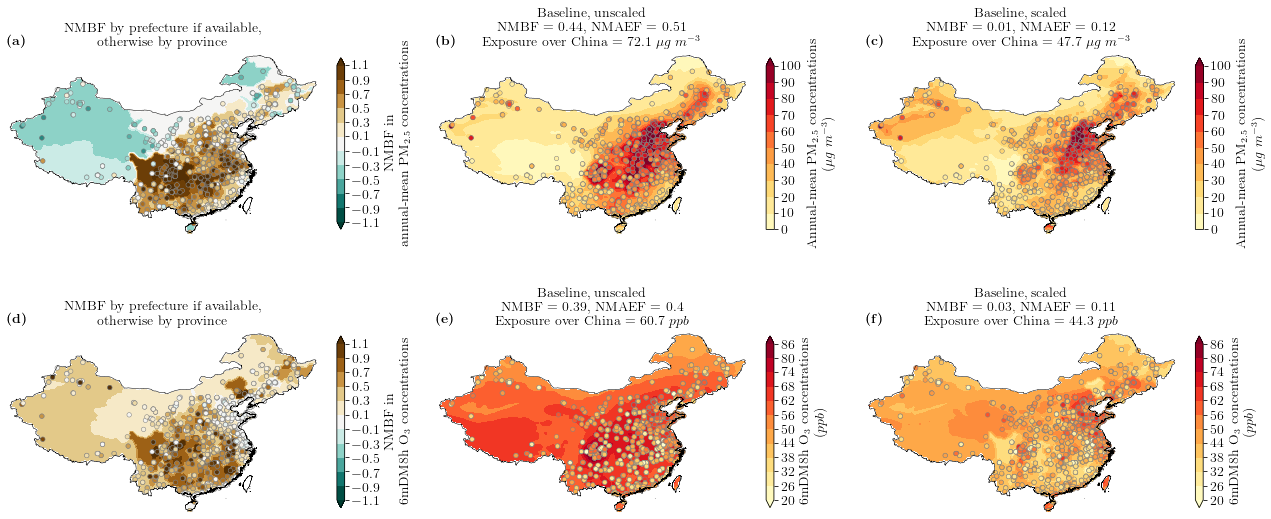

In [19]:
fig = plt.figure(1, figsize=(18, 12))
gs = gridspec.GridSpec(2, 3)

make_plot(0, prefecture_nmbf_PM2_5_DRY_china, True, df_obs['nmbf_PM2_5_DRY'], 'NMBF in \nannual-mean PM$_{2.5}$ concentrations', np.linspace(-1.1, 1.1, 12), 'BrBG_r', 'both', 'NMBF by prefecture if available,\notherwise by province')
make_plot(1, ds_PM2_5_DRY_china, True, df_obs['PM2_5_DRY'], 'Annual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', np.linspace(0, 100, 11), 'YlOrRd', 'max', f"Baseline, unscaled\nNMBF = {round(df_obs['nmbf_PM2_5_DRY'].mean(), 2)}, NMAEF = {round(df_obs['nmaef_PM2_5_DRY'].mean(), 2)}\n" + f"Exposure over China = {round(popweighted['baseline_exposure_unscaled_PM2_5_DRY_China'], 1)}" + " ${\mu}g$ $m^{-3}$")
make_plot(2, ds_PM2_5_DRY_scaled_prefecture_china, True, df_obs['PM2_5_DRY'], 'Annual-mean PM$_{2.5}$ concentrations\n (${\mu}g$ $m^{-3}$)', np.linspace(0, 100, 11), 'YlOrRd', 'max', f"Baseline, scaled\nNMBF = {round(df_obs['nmbf_PM2_5_DRY_scaled'].mean(), 2)}, NMAEF = {round(df_obs['nmaef_PM2_5_DRY_scaled'].mean(), 2)}\n" + f"Exposure over China = {round(popweighted['baseline_exposure_scaled_PM2_5_DRY_China'], 1)}" + " ${\mu}g$ $m^{-3}$")

make_plot(3, prefecture_nmbf_o3_6mDM8h_china, True, df_obs['nmbf_o3_6mDM8h'], 'NMBF in \n6mDM8h O$_{3}$ concentrations', np.linspace(-1.1, 1.1, 12), 'BrBG_r', 'both', 'NMBF by prefecture if available,\notherwise by province')
make_plot(4, ds_o3_6mDM8h_china, True, df_obs['o3_6mDM8h_ppb'], '6mDM8h O$_{3}$ concentrations\n ($ppb$)', np.linspace(20, 86, 12), 'YlOrRd', 'both', f"Baseline, unscaled\nNMBF = {round(df_obs['nmbf_o3_6mDM8h'].mean(), 2)}, NMAEF = {round(df_obs['nmaef_o3_6mDM8h'].mean(), 2)}\n" + f"Exposure over China = {round(popweighted['baseline_exposure_unscaled_o3_6mDM8h_China'], 1)}" + " $ppb$")
make_plot(5, ds_o3_6mDM8h_scaled_prefecture_china, True, df_obs['o3_6mDM8h_ppb'], '6mDM8h O$_{3}$ concentrations\n ($ppb$)', np.linspace(20, 86, 12), 'YlOrRd', 'both', f"Baseline, scaled\nNMBF = {round(df_obs['nmbf_o3_6mDM8h_scaled'].mean(), 2)}, NMAEF = {round(df_obs['nmaef_o3_6mDM8h_scaled'].mean(), 2)}\n" + f"Exposure over China = {round(popweighted['baseline_exposure_scaled_o3_6mDM8h_China'], 1)}" + " $ppb$")

gs.tight_layout(fig, rect=[0, 0, 1.0, 0.75]) 

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/nmbf_unscaled_scaled_concentrations.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/nmbf_unscaled_scaled_concentrations.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()